# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [1]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-curand-cu12 10.3.9.90 which is incompatible.


In [2]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [4]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

(…)-00000-of-00005-3ac4e3b3fa8df68d.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00001-of-00005-72e716d68bb13413.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00002-of-00005-8dd97810f77d7a20.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00003-of-00005-0e1eda89906f6ebb.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00004-of-00005-cbbd007c0641d389.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00000-of-00001-cef82967b9d8e57e.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


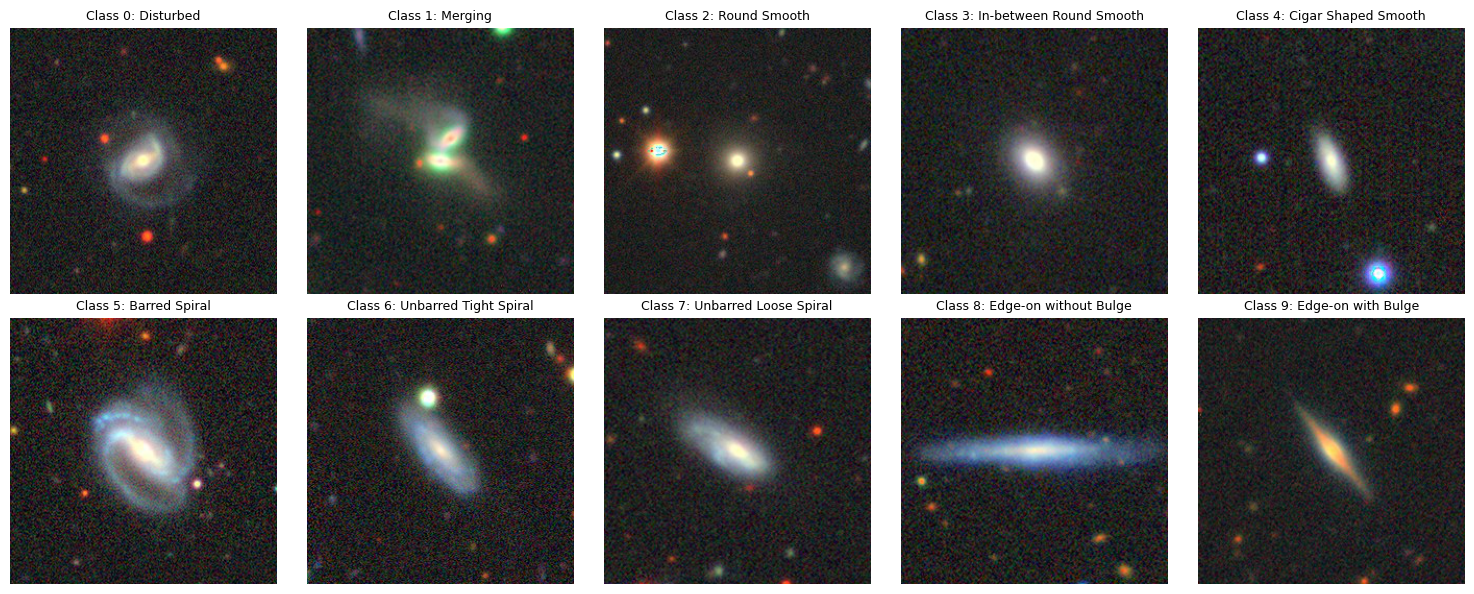

In [5]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Your training code here

In [6]:
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import timm
from timm.data import create_dataset, create_loader
from timm.loss import LabelSmoothingCrossEntropy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
class HuggingFaceImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        label = item["label"]
        if self.transform:
            image = self.transform(image=np.array(image).copy())
        return image, label


In [8]:
# --- Config ---
CFG = {
    "model_name": "nfnet_l0.ra2_in1k", 
    "num_classes": 10,         # Galaxy10 DECals has 10 classes
    "batch_size": 32,
    "lr": 0.001,
    "epochs": 90,
    "image_size": 224,
    "smoothing": 0.1,          # Label smoothing
    "rand_augment": True,      # Use RandAugment
    "TTA": True,               # Enable Test-Time Augmentation
}

In [9]:
def compute_dataset_stats(dataset, batch_size=32, num_workers=4):
    """
    Compute mean and std of a dataset across RGB channels.
    
    Args:
        dataset: PyTorch dataset returning (image, label) tuples
        batch_size: batch size for computation
        num_workers: number of workers for DataLoader
        
    Returns:
        mean: per-channel mean (shape: [3])
        std: per-channel std (shape: [3])
    """
    # Create a basic loader without any normalization
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )
    
    # Initialize variables
    mean = 0.0
    std = 0.0
    nb_samples = 0
    
    # Disable any augmentation/normalization in transforms
    for images, _ in tqdm(loader, desc="Computing stats"):
        if isinstance(images, dict):  # Handle case where images are in dict
            images = images['image'].double()

        # Rearrange dimensions to [batch_size, channels, height, width]
        images = images.permute(0, 1, 2, 3)

        # print('images.shape ', images.shape)
        
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        
        # Update mean and std
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    
    # Final calculations
    mean /= nb_samples
    std /= nb_samples
    
    return mean.numpy(), std.numpy()

# Usage example:
# First create a dataset without normalization in transforms
basic_transform = A.Compose([
    A.Resize(CFG["image_size"], CFG["image_size"]),
    ToTensorV2(),  # Only convert to tensor, no normalization
])

raw_dataset = HuggingFaceImageDataset(galaxy_dataset['train'], transform=basic_transform)

# Compute stats
mean, std = compute_dataset_stats(raw_dataset)
print(f"Mean: {mean / 255}")
print(f"Std: {std / 255}")

Computing stats: 100%|██████████| 499/499 [00:32<00:00, 15.24it/s]

Mean: [0.16703898 0.16213532 0.15842129]
Std: [0.11802412 0.10757561 0.09988286]


In [10]:
# --- Data Augmentation ---
def get_transforms(train=True):
    if train:
        transform = A.Compose([
            A.RandomResizedCrop(size=(CFG["image_size"], CFG["image_size"]), scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(p=0.5),
            A.Normalize(mean=[0.16, 0.16, 0.16], std=[0.12, 0.1, 0.1]),
            ToTensorV2(),
        ])
    else:
        transform = A.Compose([
            A.Resize(CFG["image_size"], CFG["image_size"]),
            A.CenterCrop(CFG["image_size"], CFG["image_size"]),
            A.Normalize(mean=[0.16, 0.16, 0.16], std=[0.12, 0.1, 0.1]),
            ToTensorV2(),
        ])
    return transform

# --- Dataset/Loader (Replace with Galaxy10 DECals) ---
train_dataset = HuggingFaceImageDataset(galaxy_dataset['train'], transform=get_transforms(train=True))
val_dataset = HuggingFaceImageDataset(galaxy_dataset['test'], transform=get_transforms(train=False))
train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG["batch_size"], shuffle=False)

# --- Model ---
model = timm.create_model(
    CFG["model_name"],
    pretrained=True,
    num_classes=CFG["num_classes"],
)
model = model.to("cuda")

# --- Loss & Optimizer ---
criterion = LabelSmoothingCrossEntropy(smoothing=CFG["smoothing"])
optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=0.01)

# --- Training Loop ---
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    for images, labels in loader:
        # print("images ", images)
        images, labels = images['image'].to("cuda"), labels.to("cuda")

        # print("images.shape ", images.shape)
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        optimizer.step()

# --- Validation Loop (with TTA) ---
def evaluate_tta(model, loader, n_tta=4):
    model.eval()
    all_preds, all_labels = [], []
    tta_transforms = [
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.RandomRotate90(p=1.0),
        A.NoOp(p=1.0),  # Identity transform
    ]

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images['image'].to("cuda"), labels.to("cuda")
            batch_size = images.size(0)
            tta_preds = []

            for tta_idx in range(n_tta):
                if tta_idx < len(tta_transforms):
                    transform = tta_transforms[tta_idx]
                else:
                    transform = A.NoOp(p=1.0)

                # Apply transform: need to de-normalize first
                imgs_np = images.cpu().permute(0, 2, 3, 1)  # [B,H,W,C]
                imgs_np = (imgs_np * torch.tensor([0.12, 0.1, 0.1]).view(1,1,1,3) + 
                           torch.tensor([0.16, 0.16, 0.16]).view(1,1,1,3)).numpy()
                imgs_np = (imgs_np * 255.0).clip(0,255).astype(np.uint8)

                augmented_imgs = np.stack([
                    transform(image=img)["image"] for img in imgs_np
                ])

                # Re-normalize
                augmented_imgs = augmented_imgs.astype(np.float32) / 255.0
                augmented_imgs = (augmented_imgs - np.array([0.16, 0.16, 0.16])) / np.array([0.12, 0.1, 0.1])
                augmented_imgs = torch.from_numpy(augmented_imgs).permute(0,3,1,2).to("cuda")  # [B,3,H,W]

                preds = model(augmented_imgs.float()).softmax(dim=1)
                tta_preds.append(preds)

            # Average TTA predictions
            tta_preds = torch.stack(tta_preds).mean(dim=0)
            all_preds.append(tta_preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds.argmax(dim=1) == all_labels).float().mean().item()
    return accuracy, all_preds.argmax(dim=1)


# --- Main Training Loop ---
best_accuracy = 0.0
for epoch in range(CFG["epochs"]):
    train_one_epoch(model, train_loader, optimizer, criterion)
    val_accuracy, preds = evaluate_tta(model, val_loader) if CFG["TTA"] else evaluate(model, val_loader)
    
    print(f"Epoch {epoch+1}/{CFG['epochs']}, Val Accuracy: {val_accuracy:.4f}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_nfnet_galaxy10.pth")

print(f"Best Accuracy: {best_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

Epoch 1/90, Val Accuracy: 0.7796
Epoch 2/90, Val Accuracy: 0.8072
Epoch 3/90, Val Accuracy: 0.8100
Epoch 4/90, Val Accuracy: 0.8207
Epoch 5/90, Val Accuracy: 0.8523
Epoch 6/90, Val Accuracy: 0.8399
Epoch 7/90, Val Accuracy: 0.8309
Epoch 8/90, Val Accuracy: 0.8517
Epoch 9/90, Val Accuracy: 0.8478
Epoch 10/90, Val Accuracy: 0.8687
Epoch 11/90, Val Accuracy: 0.8568
Epoch 12/90, Val Accuracy: 0.8506
Epoch 13/90, Val Accuracy: 0.8692
Epoch 14/90, Val Accuracy: 0.8540
Epoch 15/90, Val Accuracy: 0.8563
Epoch 16/90, Val Accuracy: 0.8737
Epoch 17/90, Val Accuracy: 0.8658
Epoch 18/90, Val Accuracy: 0.8636
Epoch 19/90, Val Accuracy: 0.8512
Epoch 20/90, Val Accuracy: 0.8715
Epoch 21/90, Val Accuracy: 0.8760
Epoch 22/90, Val Accuracy: 0.8675
Epoch 23/90, Val Accuracy: 0.8596
Epoch 24/90, Val Accuracy: 0.8664
Epoch 25/90, Val Accuracy: 0.8681
Epoch 26/90, Val Accuracy: 0.8698
Epoch 27/90, Val Accuracy: 0.8811
Epoch 28/90, Val Accuracy: 0.8766
Epoch 29/90, Val Accuracy: 0.8833
Epoch 30/90, Val Accura

# Evaluation

Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8720
Weighted Precision: 0.8699
Weighted Recall: 0.8720
Weighted F1-Score: 0.8698
-------------------------
Per-Class Metrics:
Class                          | Precision  | Recall     | F1-Score   | Support   
--------------------------------------------------------------------------------
0: Disturbed                   | 0.7143     | 0.6422     | 0.6763     | 109       
1: Merging                     | 0.9322     | 0.8919     | 0.9116     | 185       
2: Round Smooth                | 0.8821     | 0.9880     | 0.9321     | 250       
3: In-between Round Smooth     | 0.8884     | 0.9646     | 0.9249     | 198       
4: Cigar Shaped Smooth         | 0.8621     | 0.8929     | 0.8772     | 28        
5: Barred Spiral               | 0.8879     | 0.8756     | 0.8817     | 217       
6: Unbarred Tight Spiral       | 0.8129     | 0.7039     | 0.7545     | 179       
7: Unbarred Loose Spiral       | 0.79

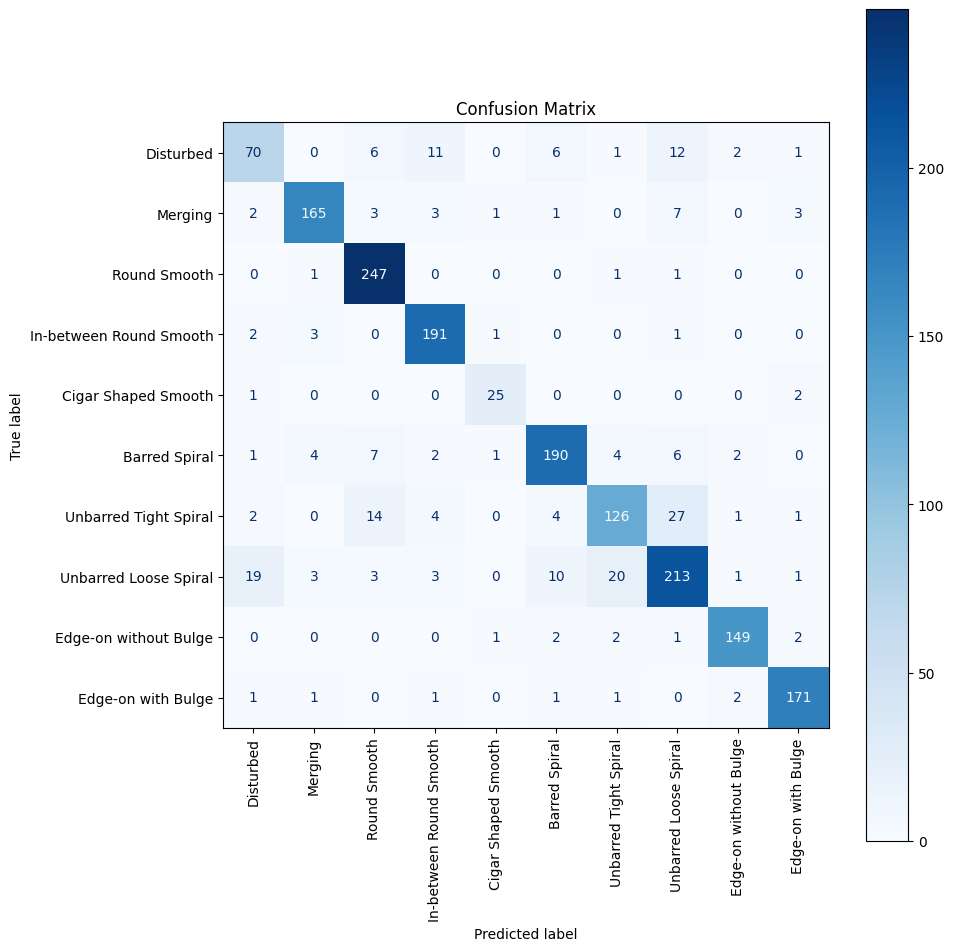

In [11]:
true_test_labels = galaxy_dataset['test']['label']
test_metrics = evaluate_predictions(preds, true_test_labels, class_names)